In [1]:
import time
import os
import math
import datetime
import random
import json
import collections
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from shapely.geometry import Point, Polygon, LineString
from shapely.ops import cascaded_union

NOT_AVAILABLE_MSG = "No Available Trip in The Given Service Day"



In [2]:
# trips_df = pd.read_csv("../../../data/mmt_gtfs/trips.csv")
# routes_df = pd.read_csv("../../../data/mmt_gtfs/routes.csv")
# stops_df = pd.read_csv("../../../data/bus_route_stop_info/stops.csv")
# stops_df = stops_df[stops_df["Route"] != "None"]  # filter stops that are not currently in service
# stop_times_df = pd.read_csv("../../../data/mmt_gtfs/stop_times.csv")
# calender_df = pd.read_csv("../../../data/mmt/calendar.csv")
city = gpd.read_file("../../../data/plot/background/madison-shp")
water = gpd.read_file("../../../data/plot/background/water-shp")
street = gpd.read_file("../../../data/plot/background/streets-shp")
# zones = gpd.read_file("../../../data/plot/background/zoning_districts-shp")
# zones = zones.dropna(subset=["ZONING_COD"])  # filter districts without ZONING_COD data
wards = gpd.read_file("../../../data/population/wards-shp")
pop = pd.read_csv("../../../data/population/population.csv")
wards = wards[wards["WARD"].isin(pop["Ward"])]
ward_areas = gpd.read_file("../../../data/plot/background/ward_area-shp")

In [3]:
# borrowed from chang's busSim
from busSim import BusSim
from graph import Graph
trips_df = pd.read_csv("../../../data/mmt/trips.csv")
routes_df = pd.read_csv("../../../data/mmt/routes.csv")
stop_times_df = pd.read_csv("../../../data/mmt/stop_times.csv")
calender_df = pd.read_csv("../../../data/mmt/calendar.csv")
stops_df = pd.read_csv("../../../data/mmt/stops.csv")


In [4]:
uw_madison = [
    55, 58, 59, 60, 61, 62, 63, 66, 67
]
mid_west = [
    64, 65, 79, 80, 81, 82, 83, 84, 85, 86, 87, 89
]
north_west = [
    88, 109, 108, 110, 120, 107, 140, 127, 111, 122, 143, 138, 124,
    104, 141, 117
]
south_west = [
    90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103,
    105, 106, 119, 137, 125, 114, 115, 116, 121, 144,
]
south = [
    68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 113, 139
]
downtown = [
    41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 56, 57
]
south_east = [
    1, 2, 3, 4, 5, 6, 7, 13, 14, 15, 132, 133, 134
]
east = [
    39, 40, 8, 9, 10, 11, 12, 16, 17, 128, 129, 130, 131,
    18, 19, 20, 22, 136, 29
]
north_east = [
    21, 23, 24, 25, 26, 126, 142, 145
]
north = [
    27, 28, 30, 31, 32, 33, 34, 35, 36, 37, 38, 112, 118, 135
]

regions = [uw_madison, mid_west, north_west, south_west, south, downtown,
           south_east, east, north_east, north]
w = []
r = []
p = []
g = []
for ward in sorted(list(set(wards["WARD"]))):

    # polygon
    if len(wards[wards["WARD"] == ward]) > 1:
        polygons = list(wards[wards["WARD"] == ward]["geometry"])
        boundary = gpd.GeoSeries(cascaded_union(polygons))
        g.append(boundary.iloc[0])
    else:
        g.append(wards[wards["WARD"] == ward].iloc[0, -1])

    # ward
    w.append(ward)

    # region
    if ward in uw_madison:
        r.append("UW Madison")
    elif ward in mid_west:
        r.append("Mid West")
    elif ward in north_west:
        r.append("North West")
    elif ward in south_west:
        r.append("South West")
    elif ward in south:
        r.append("South")
    elif ward in downtown:
        r.append("Downtown")
    elif ward in south_east:
        r.append("South East")
    elif ward in east:
        r.append("East")
    elif ward in north_east:
        r.append("North East")
    else:
        r.append("North")

    # population
    p.append(pop[pop["Ward"] == ward]["total"].sum())


temp_wards = pd.DataFrame(
    {
        "ward":w,
        "region":r,
        "population":p,
        "geometry":g
    })
temp_wards = temp_wards.set_geometry("geometry")
temp_wards.head()

regions = ["UW Madison", "Mid West", "North West", "South West", "South",
           "Downtown", "South East", "East", "North East", "North"]

population = []
polys = []
for region in regions:
    temp =  temp_wards[temp_wards["region"] == region]

    population.append(temp["population"].sum())

    polygons = list(temp["geometry"])
    boundary = gpd.GeoSeries(cascaded_union(polygons))
    polys.append(boundary.iloc[0])

reg_df = pd.DataFrame({
    "region":regions,
    "population":population,
    "geometry":polys
})
reg_df = reg_df.set_geometry("geometry")

############### plot #######################################################
# fig, (ax0, ax1) = plt.subplots(figsize=(20, 6), ncols=2)
# plt.subplots_adjust(wspace=-0.1)
#
# ax0.set_axis_off()
# ax1.set_axis_off()
#
# city.plot(ax=ax0, color="0.9", alpha=0.7, zorder=1)
# city.plot(ax=ax1, color="0.9", alpha=0.7, zorder=1)
# water.plot(ax=ax0, color="0.9", alpha=0.7, zorder=1)
# water.plot(ax=ax1, color="0.9", alpha=0.7, zorder=1)
#
# reg_df.plot(ax=ax0, column="population", legend=True, cmap='YlOrRd', zorder=2)
# reg_df.plot(ax=ax1, column="population", cmap='Accent', zorder=2)
#
# for region in regions:
#     center = reg_df[reg_df["region"] == region]["geometry"].centroid
#     ax1.text(center.x, center.y, region, ha="center", color="k", size=14)

# plt.savefig("andy1.png", dpi=400, bbox_inches="tight")

##########################################

In [5]:
reg_df.head()

,region,population,geometry
0,UW Madison,15872.937162,"POLYGON ((-89.40097 43.06766, -89.39921 43.067..."
1,Mid West,31278.867953,"POLYGON ((-89.44324 43.05115, -89.44336 43.051..."
2,North West,16972.245322,"MULTIPOLYGON (((-89.56015 43.04568, -89.56352 ..."
3,South West,36245.634873,"POLYGON ((-89.50040 43.00126, -89.50047 43.001..."
4,South,20580.988733,"MULTIPOLYGON (((-89.35804 43.03897, -89.35822 ..."


In [6]:
total_stops = []
for idx1, row1 in reg_df.iterrows():
    stops = []
    poly = row1["geometry"]
    for idx2, row2 in stops_df.iterrows():
        lat = row2["stop_lat"]
        lon = row2["stop_lon"]
        # print(lon, lat)


        if poly.contains(Point(lon, lat)):
            stops.append(row2["stop_id"])
    total_stops.append(stops)

In [7]:
reg_df["stop_ids"] = total_stops
reg_df.head(2)

,region,population,geometry,stop_ids
0,UW Madison,15872.937162,"POLYGON ((-89.40097 43.06766, -89.39921 43.067...","[5, 47, 52, 56, 60, 61, 100, 104, 113, 133, 16..."
1,Mid West,31278.867953,"POLYGON ((-89.44324 43.05115, -89.44336 43.051...","[2437, 6000, 6100, 2100, 2101, 2105, 2109, 211..."


In [8]:
### DONT RUN
# dts = []
# for hr in range(24):
#     if hr > 4:
#         dts.append("{}:00:00".format(hr))
#         if hr == 23:
#             break
#         dts.append("{}:30:00".format(hr))
#
#
# avg_areas = {reg : [] for reg in regions}
# step = 10
#
# DATA_PATH = "../../../data"
# DAY = "monday"
# # START_TIME = "12:00:00"
# ELAPSE_TIME = "00:20:00"
# AVG_WALKING_SPEED = 1.4 # 1.4 meters per second
# MAX_WALKING_MIN = 10
# for dt in dts:
#
#     START_TIME = dt
#
#     busSim = BusSim(DATA_PATH, DAY, START_TIME, ELAPSE_TIME,
#                     AVG_WALKING_SPEED, MAX_WALKING_MIN)
#
#     reg = 0
#     found = 0
#     not_found = 0
#     area_times = []
#     for idx, row in reg_df.iterrows():
#         areas = []
#         reg = row["region"]
#         temp = stops_df[stops_df["stop_id"].isin(row["stop_ids"])]
#         # print("len(temp) = ", len(temp))
#
#         step_cnt = 0
#         for idx1, row1 in temp.iterrows():
#             if step_cnt % step == 0:
#                 step_cnt += 1
#                 id = row1["stop_id"]
#                 try:
#                     gdf = busSim.get_gdf(start_stop=id)
#                     a = busSim.get_area(gdf)
#                     # print(a)
#                     areas.append(a)
#                     found += 1
#                 except:
#                     not_found += 1
#                     continue
#             else:
#                 step_cnt += 1
#                 continue
#
#
#         if len(areas) == 0:
#             area_times.append(sum(areas) / (len(areas) + 1))
#             # print("len(area) = 0")
#         else:
#             area_times.append(sum(areas) / (len(areas)))
#
#     print("dt = {}, found = {}, not_found = {}".format(dt, found, not_found))
#
#     for i in range(len(area_times)):
#         avg_areas[regions[i]].append(area_times[i])
#
# avg_areas

dt = 5:00:00, found = 4, not_found = 175
dt = 5:30:00, found = 44, not_found = 135
dt = 6:00:00, found = 71, not_found = 108
dt = 6:30:00, found = 86, not_found = 93
dt = 7:00:00, found = 85, not_found = 94
dt = 7:30:00, found = 88, not_found = 91
dt = 8:00:00, found = 81, not_found = 98
dt = 8:30:00, found = 86, not_found = 93
dt = 9:00:00, found = 78, not_found = 101
dt = 9:30:00, found = 81, not_found = 98
dt = 10:00:00, found = 77, not_found = 102
dt = 10:30:00, found = 80, not_found = 99
dt = 11:00:00, found = 77, not_found = 102
dt = 11:30:00, found = 80, not_found = 99
dt = 12:00:00, found = 79, not_found = 100
dt = 12:30:00, found = 80, not_found = 99
dt = 13:00:00, found = 79, not_found = 100
dt = 13:30:00, found = 80, not_found = 99
dt = 14:00:00, found = 79, not_found = 100
dt = 14:30:00, found = 80, not_found = 99
dt = 15:00:00, found = 86, not_found = 93
dt = 15:30:00, found = 86, not_found = 93
dt = 16:00:00, found = 88, not_found = 91
dt = 16:30:00, found = 87, not_found

{'UW Madison': [0.0,
  5589091.100486073,
  8041392.527955231,
  10311340.63582287,
  12176573.586877465,
  10688334.713394621,
  12215518.741623683,
  9847115.162713498,
  11455028.440737808,
  9803863.502501441,
  11472888.342194274,
  9807352.34130908,
  11350958.847103348,
  9667715.8413756,
  11350958.847103348,
  9667715.8413756,
  11503648.981900193,
  9667715.8413756,
  11503648.981900193,
  9805090.248770406,
  12264460.537584634,
  11023279.282158686,
  12964829.827014662,
  12035635.34175702,
  13152248.06342864,
  11603763.095656106,
  12537654.813577918,
  9375197.99643039,
  9047879.32265259,
  9924834.576813271,
  9384865.463862538,
  8823010.43085764,
  9584146.607140487,
  10491697.996922733,
  9085327.677684488,
  10215663.767825995,
  5477341.365306214],
 'Mid West': [0.0,
  6965805.171597521,
  8605222.47201146,
  12154325.52627127,
  8248847.550331134,
  10642453.956131196,
  9056667.15366761,
  10778675.761030281,
  9056667.15366761,
  9986661.192588473,
  8570113

In [20]:
dfs = pd.DataFrame(avg_areas, index=dts)
dfs.head()

,UW Madison,Mid West,North West,South West,South,Downtown,South East,East,North East,North
5:00:00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.207003e+05,0.000000e+00,1.645652e+06,0.000000e+00,4.824837e+06
5:30:00,5.589091e+06,6.965805e+06,5.478881e+06,5.150660e+06,5.270289e+06,6.679976e+06,0.000000e+00,4.860907e+06,6.203439e+06,3.108156e+06
6:00:00,8.041393e+06,8.605222e+06,1.222972e+06,1.069514e+07,6.362931e+06,8.690105e+06,0.000000e+00,6.778397e+06,5.830619e+06,8.465215e+06
6:30:00,1.031134e+07,1.215433e+07,8.193155e+06,8.273975e+06,6.045320e+06,9.086579e+06,1.125086e+06,7.543473e+06,4.345178e+06,8.599180e+06
7:00:00,1.217657e+07,8.248848e+06,6.058737e+06,1.079184e+07,5.669549e+06,1.204878e+07,0.000000e+00,6.575731e+06,8.136740e+06,8.895570e+06


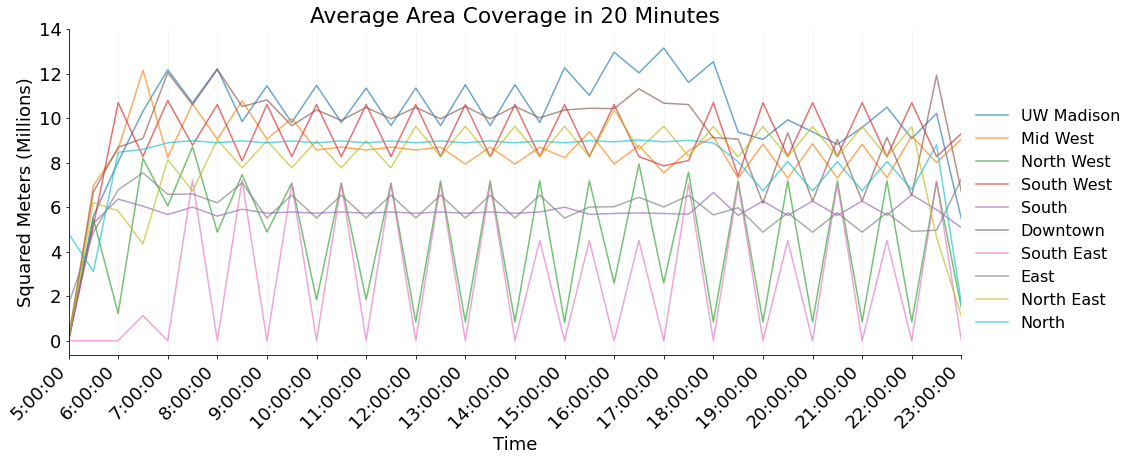

In [38]:
fig, ax = plt.subplots(figsize=(16, 6))
plt.rcParams["font.size"] = 18

for reg in regions:
    ax.plot(dfs.index, dfs[reg], label=reg, alpha=0.65)

ax.set_xlim((0, 36))
ax.set_xticks(np.arange(0, 37, 2))
ax.set_xticklabels([dts[i] for i in range(len(dts)) if i % 2 == 0],
                   rotation=45, ha="right")

ax.set_ylim = ((0, 14*1e6))
ax.set_yticks(np.arange(0, 15, 2) * 1e6)
ax.set_yticklabels([0, 2, 4, 6, 8, 10, 12, 14])

ax.set_title("Average Area Coverage in 20 Minutes")
ax.grid(axis='x', color='0.95')
ax.legend(frameon=False, fontsize=16, bbox_to_anchor=(1.0, 0.8))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_xlabel("Time")
ax.set_ylabel("Squared Meters (Millions)")
plt.savefig("final/avg.png", dpi=400, bbox_inches="tight")

In [96]:
riderships = pd.read_csv("../../../data/ridership/by_stop_and_route/weekday.csv")
riderships.head()

,OBJECTID,StopID,Route,Lat,Lon,DailyBoard,DotSize,geometry
0,20007,5,80,43.071061,-89.407019,322.93,3229261.32,POINT (-89.40701296564816 43.07105305839906)
1,20008,10,80,43.075897,-89.400235,875.26,8752643.70,POINT (-89.40022896695245 43.07588905701752)
2,20009,10,81,43.075897,-89.400235,79.74,797389.24,POINT (-89.40022896695245 43.07588905701752)
3,20010,10,82,43.075897,-89.400235,16.90,168965.00,POINT (-89.40022896695245 43.07588905701752)
4,20011,25,81,43.075849,-89.396996,24.06,240553.18,POINT (-89.39698996777406 43.07584105689991)


In [98]:
sums = []
for idx, row in reg_df.iterrows():
    ids = row["stop_ids"]
    r_sum = riderships[riderships["StopID"].isin(ids)]["DailyBoard"].sum()
    sums.append(r_sum)
sums

[18802.300000000003,
 5373.25,
 658.3,
 568.1600000000001,
 2899.67,
 14956.06,
 467.0,
 2677.83,
 858.49,
 2581.2799999999997]

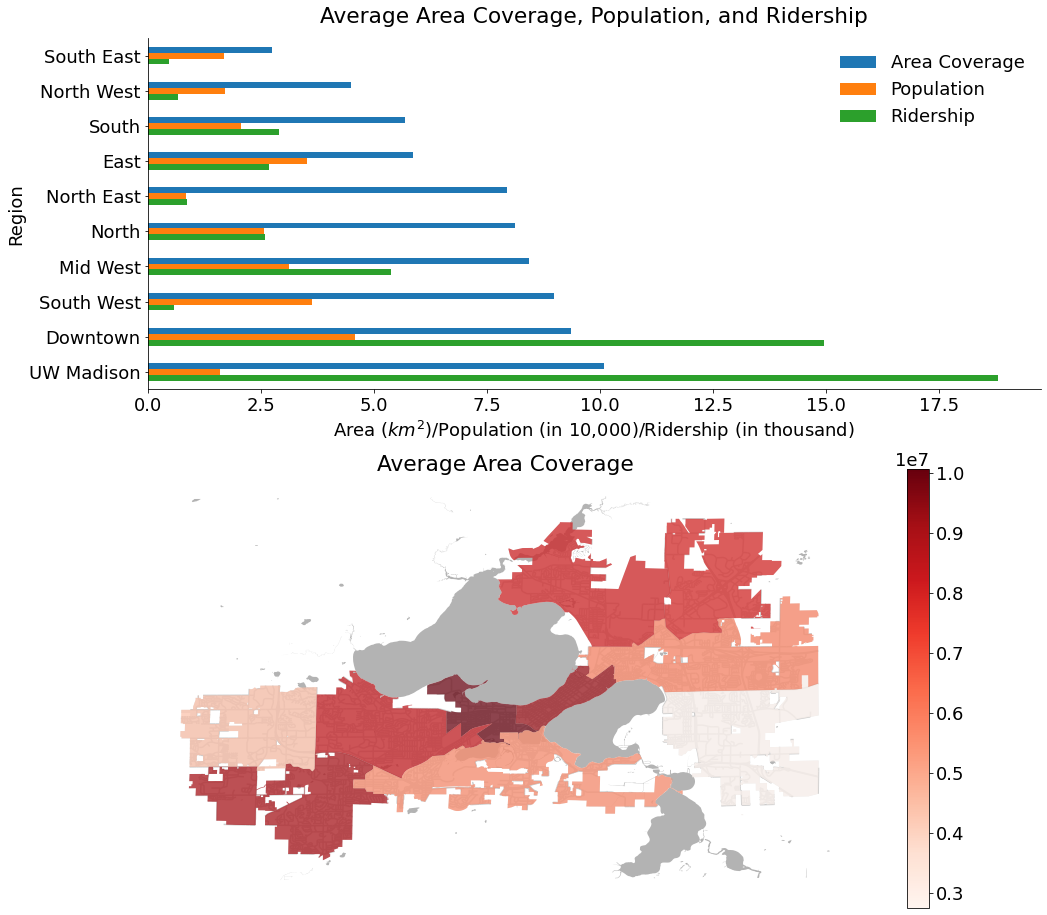

In [106]:
fig, ((ax), (ax1)) = plt.subplots(figsize=(16, 16), nrows=2, gridspec_kw={'height_ratios': [4, 5]})
plt.rcParams["font.size"] = 18

temp = pd.DataFrame({
    "Area Coverage" : [m / 1e6 for m in list(dfs.mean())],  # m^2 -> km^2
    "Population" : [p / 1e4 for p in list(reg_df["population"])],  # 10,000 -> 1 * 10,000
    "Ridership": [s / 1e3 for s in sums]  # 1000 -> 1k
}, index=regions)

temp.sort_values(by=['Area Coverage']).plot.barh(ax=ax)
ax.legend(frameon=False)

ax.invert_yaxis()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_title("Average Area Coverage, Population, and Ridership", pad=15)

ax.set_xlabel(r"Area ($km^2$)/Population (in 10,000)/Ridership (in thousand)")
ax.set_ylabel("Region")

city.plot(ax=ax1, color="0.9")
water.plot(ax=ax1, color="0.7")
street.plot(ax=ax1, color="0.8")
temp = reg_df.copy()
temp["Area_Coverage"] = list(dfs.mean())
temp = temp.set_geometry("geometry")
temp.plot(ax=ax1, column="Area_Coverage", cmap='Reds', zorder=2, alpha=0.7, legend=True)
ax1.set_axis_off()
ax1.set_title("Average Area Coverage")

plt.savefig("final/avg-good-2.png", dpi=300, bbox_inches="tight")

In [36]:
# DONT RUN
routes = sorted(list(set(routes_df["route_short_name"])))

### DONT RUN
dts = []
for hr in range(24):
    if hr > 4:
        dts.append("{}:00:00".format(hr))
        if hr == 23:
            break
        dts.append("{}:30:00".format(hr))



step = 10

DATA_PATH = "../../../data"
DAY = "monday"
# START_TIME = "12:00:00"
ELAPSE_TIME = "00:20:00"
AVG_WALKING_SPEED = 1.4 # 1.4 meters per second
MAX_WALKING_MIN = 10

avg_area_rm_all_routes = {route : [] for route in routes}
for route in routes:
    avg_areas_rm = {reg : [] for reg in regions}
    for dt in dts:

        START_TIME = dt

        busSim = BusSim(DATA_PATH, DAY, START_TIME, ELAPSE_TIME,
                        AVG_WALKING_SPEED, MAX_WALKING_MIN, route_remove=[route])

        reg = 0
        found = 0
        not_found = 0
        area_times = []
        for idx, row in reg_df.iterrows():
            areas = []
            reg = row["region"]
            temp = stops_df[stops_df["stop_id"].isin(row["stop_ids"])]
            # print("len(temp) = ", len(temp))

            for idx1, row1 in temp[::15].iterrows():
                id = row1["stop_id"]
                try:
                    gdf = busSim.get_gdf(start_stop=id)
                    a = busSim.get_area(gdf)
                    # print(a)
                    areas.append(a)
                    found += 1
                except:
                    not_found += 1
                    continue


            if len(areas) == 0:
                area_times.append(sum(areas) / (len(areas) + 1))
                # print("len(area) = 0")
            else:
                area_times.append(sum(areas) / (len(areas)))

        print("dt = {}, found = {}, not_found = {}".format(dt, found, not_found))

        for i in range(len(area_times)):
            avg_areas_rm[regions[i]].append(area_times[i])

    avg_area_rm_all_routes[route].append(avg_areas_rm)

dt = 5:00:00, found = 4, not_found = 117
dt = 5:30:00, found = 23, not_found = 98
dt = 6:00:00, found = 50, not_found = 71
dt = 6:30:00, found = 55, not_found = 66
dt = 7:00:00, found = 60, not_found = 61
dt = 7:30:00, found = 57, not_found = 64
dt = 8:00:00, found = 59, not_found = 62
dt = 8:30:00, found = 55, not_found = 66
dt = 9:00:00, found = 58, not_found = 63
dt = 9:30:00, found = 53, not_found = 68
dt = 10:00:00, found = 58, not_found = 63
dt = 10:30:00, found = 52, not_found = 69
dt = 11:00:00, found = 58, not_found = 63
dt = 11:30:00, found = 52, not_found = 69
dt = 12:00:00, found = 58, not_found = 63
dt = 12:30:00, found = 52, not_found = 69
dt = 13:00:00, found = 58, not_found = 63
dt = 13:30:00, found = 52, not_found = 69
dt = 14:00:00, found = 58, not_found = 63
dt = 14:30:00, found = 52, not_found = 69
dt = 15:00:00, found = 62, not_found = 59
dt = 15:30:00, found = 54, not_found = 67
dt = 16:00:00, found = 61, not_found = 60
dt = 16:30:00, found = 54, not_found = 67
dt

KeyboardInterrupt: 

In [ ]:
avg_area_rm_all_routes